# EDA for stores
Deeper dive than done in `src/eda/eda_main`

In [ ]:
from config import proj
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import pyspark.sql.functions as sf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
stores = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("stores.parquet")))
stores.show(5)

+---------+-------------+--------------------+----+-------+
|store_nbr|         city|               state|type|cluster|
+---------+-------------+--------------------+----+-------+
|        1|        Quito|           Pichincha|   D|     13|
|        2|        Quito|           Pichincha|   D|     13|
|        3|        Quito|           Pichincha|   D|      8|
|        4|        Quito|           Pichincha|   D|      9|
|        5|Santo Domingo|Santo Domingo de ...|   D|      4|
+---------+-------------+--------------------+----+-------+
only showing top 5 rows



### Store association with cluster, state, etc

#### Type-Cluster

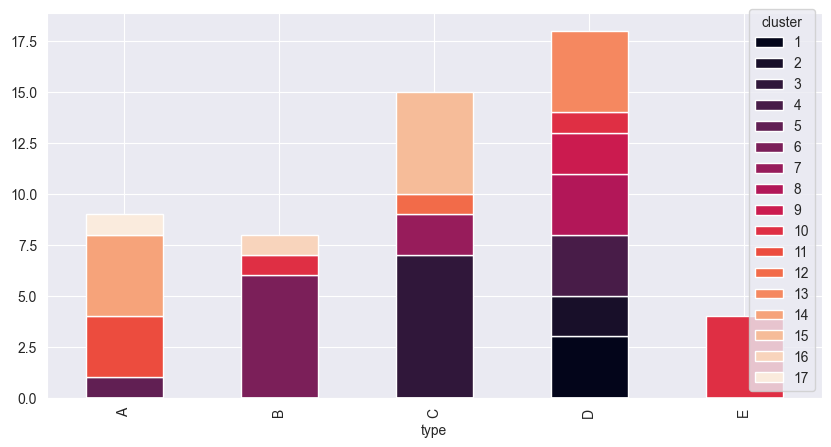

In [3]:
# Small enough to deal with pandas
stores_pd = stores.toPandas()

# Create dataset for stacked plot
store_cluster_type = stores_pd.groupby(["type", "cluster"]).size()
store_cluster_type = store_cluster_type.unstack()

# Get cols and rearrange so they show nicely on plot
cols = list(store_cluster_type.columns.values)
cols.sort(key=int)

# plot
store_cluster_type[cols].plot(kind="bar", stacked=True, figsize=(10,5), colormap="rocket")
plt.show()

In [4]:
stores_pd.groupby(["type", "cluster"]).size()

type  cluster
A     11         3
      14         4
      17         1
      5          1
B     10         1
      16         1
      6          6
C     12         1
      15         5
      3          7
      7          2
D     1          3
      10         1
      13         4
      2          2
      4          3
      8          3
      9          2
E     10         4
dtype: int64

In [5]:
stores_pd.groupby(["cluster", "type"]).size()

cluster  type
1        D       3
10       B       1
         D       1
         E       4
11       A       3
12       C       1
13       D       4
14       A       4
15       C       5
16       B       1
17       A       1
2        D       2
3        C       7
4        D       3
5        A       1
6        B       6
7        C       2
8        D       3
9        D       2
dtype: int64

- E type is a single cluster
- D is the only one to contain cluster 1
- There is no overlap with the clusters except for cluster 10, which has B, D and E

#### State-cluster

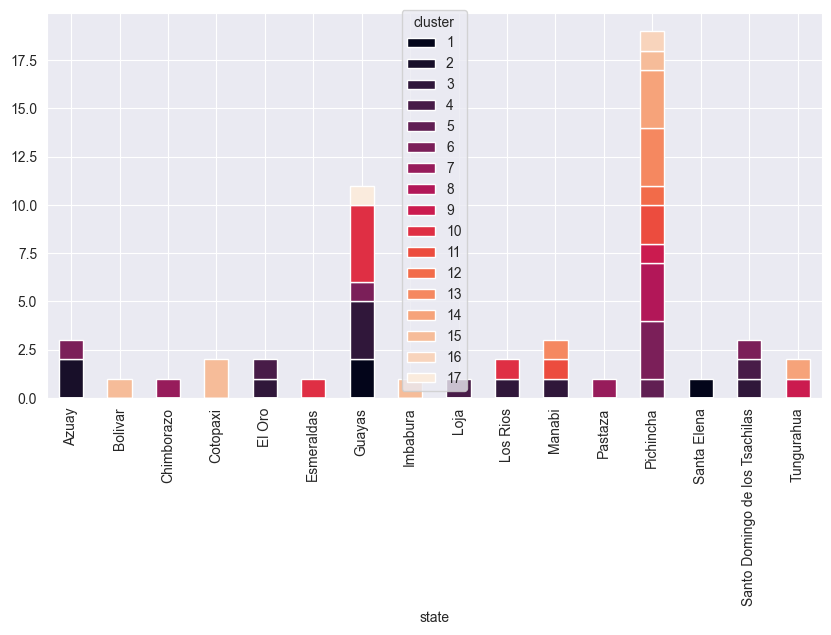

In [6]:
# Small enough to deal with pandas
stores_pd = stores.toPandas()

# Create dataset for stacked plot
store_cluster_type = stores_pd.groupby(["state", "cluster"]).size()
store_cluster_type = store_cluster_type.unstack()

# Get cols and rearrange so they show nicely on plot
cols = list(store_cluster_type.columns.values)
cols.sort(key=int)

# plot
store_cluster_type[cols].plot(kind="bar", stacked=True, figsize=(10,5), colormap="rocket")
plt.show()

Multiple clusters in each state, therefore clusters aren't necessarily built from state information. They could be more to do with regional/city or affluence properties.

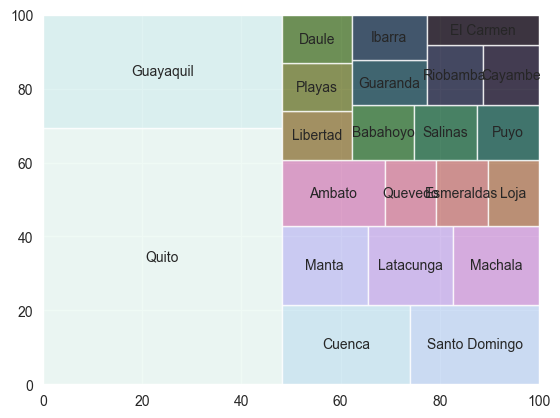

In [7]:
store_city = stores_pd.city.value_counts()
squarify.plot(sizes=store_city, label=store_city.index, alpha=.8, color=sns.color_palette('cubehelix_r', 22))
plt.show()

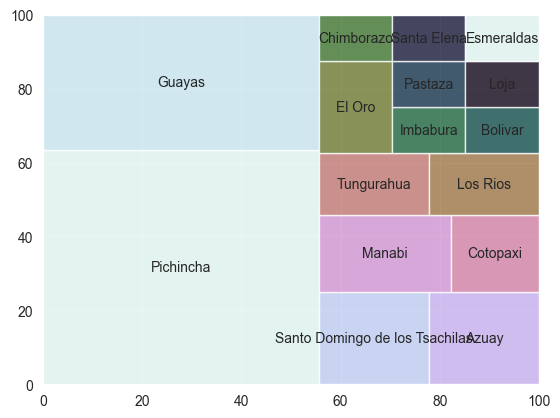

In [8]:
store_state = stores_pd.state.value_counts()
squarify.plot(sizes=store_state, label=store_state.index, alpha=.8, color=sns.color_palette('cubehelix_r', 15))
plt.show()

In [9]:
stores_pd[["state", "city"]].drop_duplicates().sort_values(by="state")

state           city
36                           Azuay         Cuenca
18                         Bolivar       Guaranda
13                      Chimborazo       Riobamba
11                        Cotopaxi      Latacunga
39                          El Oro        Machala
42                      Esmeraldas     Esmeraldas
34                          Guayas         Playas
35                          Guayas       Libertad
23                          Guayas      Guayaquil
26                          Guayas          Daule
14                        Imbabura         Ibarra
37                            Loja           Loja
30                        Los Rios       Babahoyo
32                        Los Rios        Quevedo
51                          Manabi          Manta
53                          Manabi      El Carmen
21                         Pastaza           Puyo
0                        Pichincha          Quito
10                       Pichincha        Cayambe
24                     Santa Elena        Salinas
4   Santo Domingo de los Tsachilas  Santo Domingo
22                      Tungurahua         Ambato

Pichincha has a lot of stores, mostly due to Quito having so many

### Store open/close dates

In [10]:
transactions = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("transactions.parquet")))
txn = transactions.toPandas()

In [11]:
max_min_dates = txn.groupby(['store_nbr']).agg({'date':[min , max]}).reset_index()
pd.DatetimeIndex(max_min_dates.date["min"]).year.value_counts()

2013    47
2015     5
2017     1
2014     1
Name: min, dtype: int64

Most stores open from the start of transactions